In [1]:
import os
os.chdir('../')

In [2]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np
import torch

from src.DRL.qnetwork import QNetwork
from src.XAI.concept import Concept
from src.XAI.concepts import concept_instances

In [3]:
layer = 4
env_steps = Concept.load_concept_data()
# Take a concept instance to get sample data
sample_concept = concept_instances['player to right']
sample_concept.prepare_data(env_steps)
test_images = sample_concept.test_images
test_obs = sample_concept.test_obs
actions = ['NOOP', 'LEFT', 'RIGHT', 'JUMP', 'DODGE']

In [4]:
model_path = QNetwork.find_newest_model()
model = QNetwork(frame_stacks=4, model_path=model_path)
print(f"Using model: {model_path}")

Using model: runs/20240128-235322/model_10000000.pt


In [5]:
concept_mean_max_gradient = {} # does adding a concept improve max(q value)?
concept_action_mean_gradient = {a:[] for a in actions} # does adding a concept improve mean(q value)?
concept_max_q_improvement = {} # does concept improve max(q value)?
concept_action_improvement = {a:[] for a in actions} # how often does concept improve action?
concept_action_max_gradient = {a:[] for a in actions} # how often did this action have the highest gradient?

In [6]:
concept_names = []
for concept in concept_instances.values():
    concept_names.append(concept.name)
    concept.prepare_data(env_steps, max_size=5000)
    probe, score = concept.load_torch_probe()
    print(f'{concept.name}: {score}')
    CAV = probe[1].weight.data.cpu().numpy().squeeze()
    CAV = torch.tensor(CAV, dtype=torch.float32)
    
    # Get Q-values and test activations
    _, acts_dict = model(torch.tensor(concept.test_obs), return_acts=True)
    acts = acts_dict[layer]
    
    # Additional forward pass to get gradients (return_acts=True detaches from graph)
    acts.requires_grad_(True)
    q_values = model.network[layer + 1:](acts)

    # Flatten the activations
    acts_flat = acts.reshape(acts.shape[0], -1)
    CAV = CAV / torch.norm(CAV)
    CAV_norm = CAV / torch.norm(CAV)

    # Initialize tensor to store results
    directional_derivatives = torch.zeros_like(q_values)

    # Compute directional derivatives
    for j in range(q_values.shape[1]):
        q_values[:, j].backward(torch.ones_like(q_values[:, j]), retain_graph=True)
        
        # Calculate directional derivative
        grads_flat = acts.grad.reshape(acts.shape[0], -1)
        directional_derivatives[:, j] = torch.mv(grads_flat, CAV_norm)
    
        acts.grad.zero_()

    # calculate mean max (as in the best action) directional derivative
    concept_mean_max_gradient[concept.name] = torch.mean(torch.max(directional_derivatives, dim=1)[0]).item()

    mean_action_derivatives = torch.mean(directional_derivatives, dim=0).tolist()
    # calculate mean directional derivative for each concept
    for i, mdd in enumerate(mean_action_derivatives):
        concept_action_mean_gradient[actions[i]].append(mdd)

    # count how often max derivative is positive
    concept_max_q_improvement[concept.name] = torch.sum(torch.max(directional_derivatives, dim=1)[0] > 0).item() / directional_derivatives.shape[0]
    # count how often each action has a positive derivative
    action_improvement_counter = {i: torch.sum(directional_derivatives[:, i] > 0).item() / directional_derivatives.shape[0] for i in range(len(actions))}
    for i, action in enumerate(actions):
        action_name = actions[i]
        concept_action_improvement[action_name].append(action_improvement_counter[i])

    # count which action has the highest derivative
    max_action = torch.argmax(directional_derivatives, dim=1)
    most_improvement_counter = {i: sum(max_action == i) / directional_derivatives.shape[0] for i in range(len(actions))}
    for i, action in enumerate(actions):
        action_name = actions[i]
        concept_action_max_gradient[action_name].append(most_improvement_counter[i].item())


player to right: 0.881
player low: 0.989
difficulty: 0.804
player in air: 0.965
player falling: 0.951
player dodging in air: 0.948
player fall velocity: 0.783
player standing on wall: 0.925
player dodging on wall: 0.945
events quantity: 0.765
visible wall: 0.896
visible bullet: 0.908
lava quantity: 0.882
coin quantity: 0.669
good visible events: 0.73
bad visible events: 0.842
two close bullets: 0.0
bullet player distance: 0.77
bullet aligned with player: 0.687
player dodging: 0.99


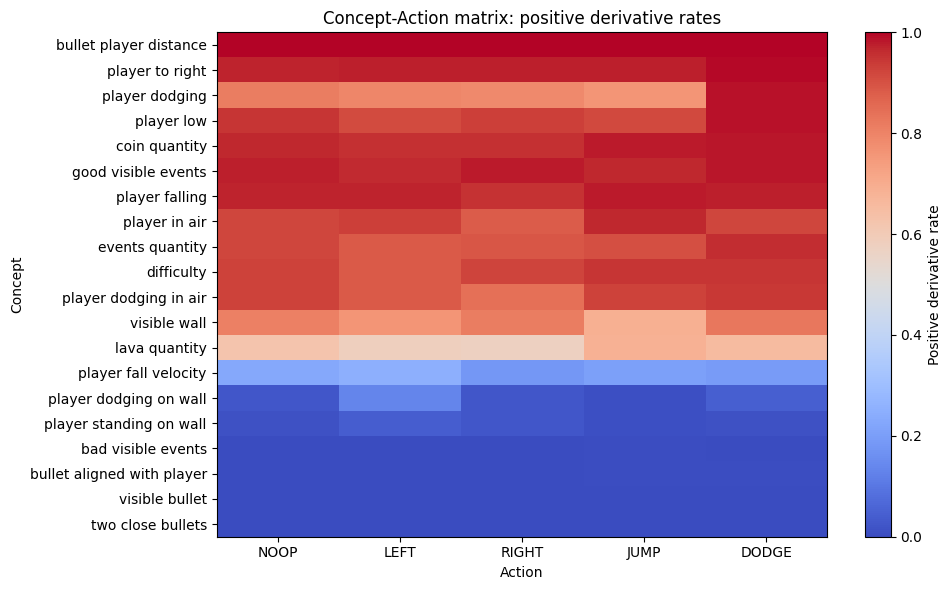

In [7]:
matrix = np.array(list(concept_action_improvement.values())).T

# Sort the matrix rows based on the max improvement value in descending order
sorted_indices = np.argsort(-matrix.max(axis=1))
sorted_matrix = matrix[sorted_indices]
sorted_concept_names = [concept_names[i] for i in sorted_indices]

plt.figure(figsize=(10, 6))
plt.imshow(sorted_matrix, cmap='coolwarm', aspect='auto', vmin=0, vmax=1)
plt.colorbar(label='Positive derivative rate')
plt.xticks(ticks=range(len(concept_action_improvement)), labels=concept_action_improvement.keys())
plt.yticks(ticks=range(len(sorted_concept_names)), labels=sorted_concept_names)
plt.title('Concept-Action matrix: positive derivative rates')
plt.xlabel('Action')
plt.ylabel('Concept')
plt.tight_layout()
plt.savefig('figures/conceptual sensitivity/concept-action-positive-matrix.png')
plt.show()

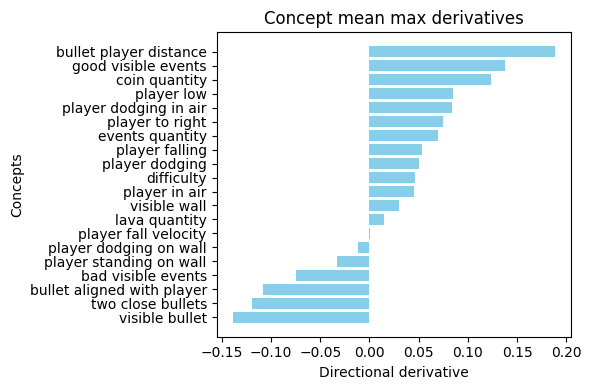

In [8]:
sorted_data = sorted(concept_mean_max_gradient.items(), key=lambda x: x[1], reverse=True)
# Extracting keys and values, and converting values to percentages
keys = [item[0] for item in sorted_data]
values = [item[1] for item in sorted_data]

# Creating the bar chart
plt.figure(figsize=(6, 4))
plt.barh(keys, values, color='skyblue')
plt.xlabel('Directional derivative')
plt.ylabel('Concepts')
plt.title('Concept mean max derivatives')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig('figures/conceptual sensitivity/mean-max-derivatives.png')
plt.show()

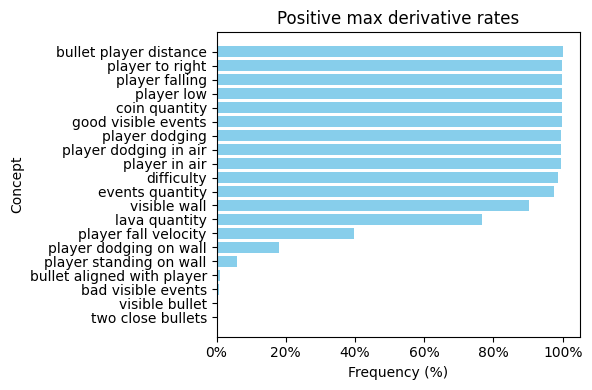

In [9]:
sorted_data = sorted(concept_max_q_improvement.items(), key=lambda x: x[1], reverse=True)
# Extracting keys and values, and converting values to percentages
keys = [item[0] for item in sorted_data]
values = [item[1] * 100 for item in sorted_data]

# Creating the bar chart
plt.figure(figsize=(6, 4))
plt.barh(keys, values, color='skyblue')
plt.xlabel('Frequency (%)')
plt.ylabel('Concept')
plt.title('Positive max derivative rates')
plt.gca().invert_yaxis()  # To display the largest values at the top
plt.gca().xaxis.set_major_formatter(mticker.PercentFormatter())
plt.gca().xaxis.set_ticks(range(0, 101, 20))
plt.tight_layout()
plt.savefig('figures/conceptual sensitivity/positive-max-derivative-rate.png')
plt.show()

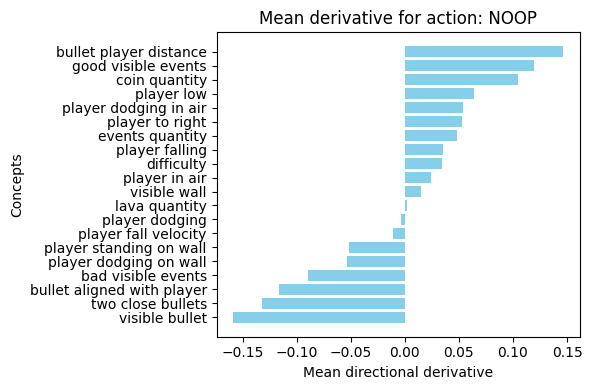

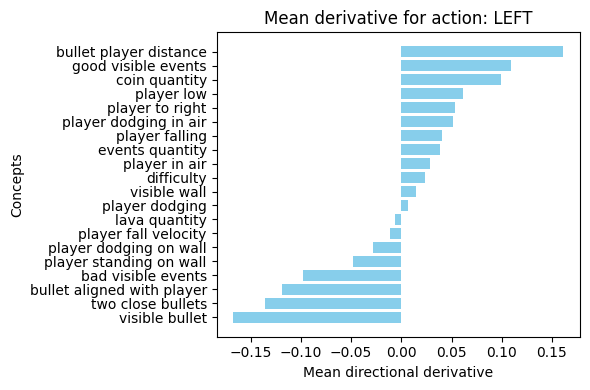

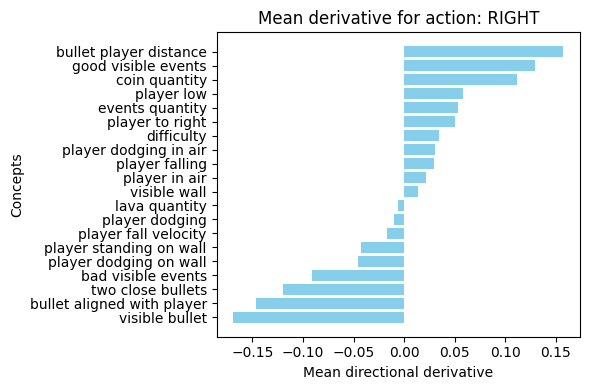

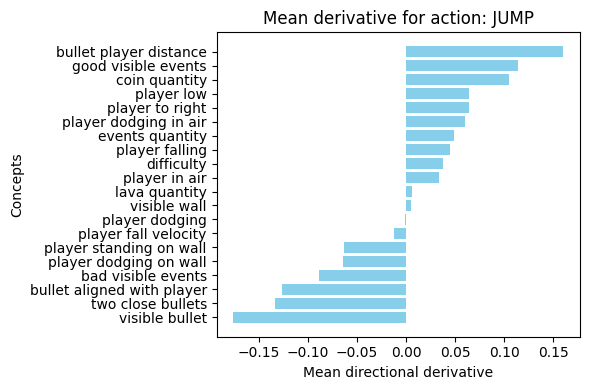

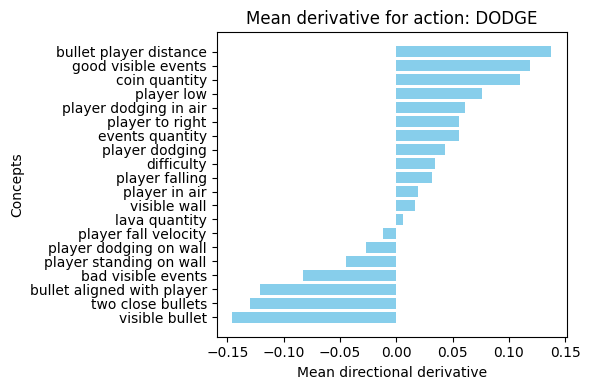

In [10]:
for action_name, values in concept_action_mean_gradient.items():
    # Sort values and concept_names together in descending order
    sorted_indices = sorted(range(len(values)), key=lambda k: values[k], reverse=True)
    sorted_values = [values[i] for i in sorted_indices]
    sorted_concept_names = [concept_names[i] for i in sorted_indices]
    
    # Plotting
    plt.figure(figsize=(6, 4))
    plt.barh(sorted_concept_names, sorted_values, color='skyblue')
    plt.xlabel('Mean directional derivative')
    plt.ylabel('Concepts')
    plt.title(f'Mean derivative for action: {action_name}')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

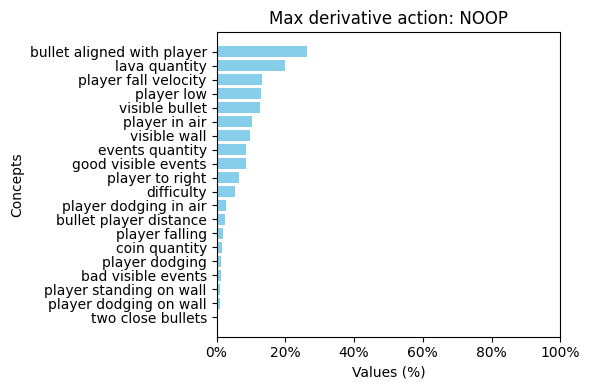

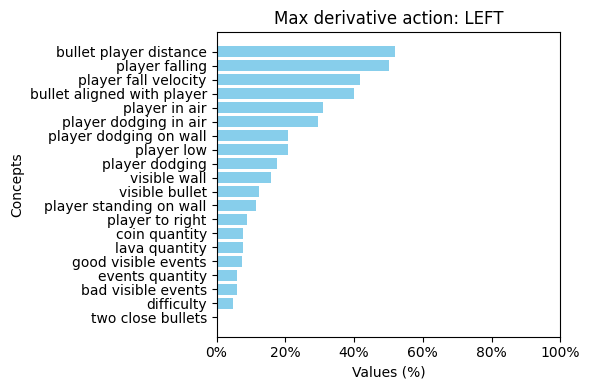

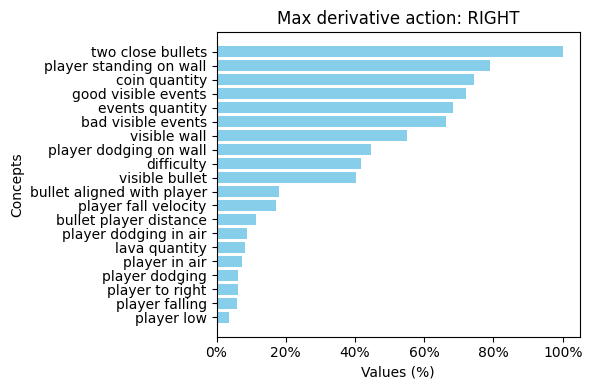

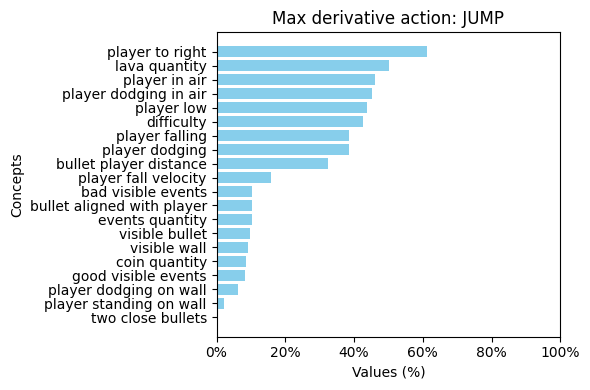

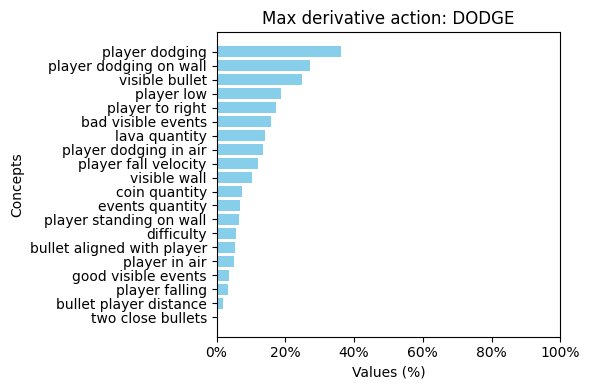

In [13]:
for action_name, values in concept_action_max_gradient.items():
    # Sort values and concept_names together in descending order
    sorted_indices = sorted(range(len(values)), key=lambda k: values[k], reverse=True)
    sorted_values = [values[i]*100 for i in sorted_indices]
    sorted_concept_names = [concept_names[i] for i in sorted_indices]
    
    # Plotting
    plt.figure(figsize=(6, 4))
    plt.barh(sorted_concept_names, sorted_values, color='skyblue')
    plt.xlabel('Values (%)')
    plt.ylabel('Concepts')
    plt.title(f'Max derivative action: {action_name}')
    plt.gca().invert_yaxis()
    plt.gca().xaxis.set_major_formatter(mticker.PercentFormatter())
    plt.gca().xaxis.set_ticks(range(0, 101, 20))
    plt.tight_layout()
    plt.savefig(f'figures/conceptual sensitivity/max-derivative-action-{action_name}.png')
    plt.show()

### this but with % improvement

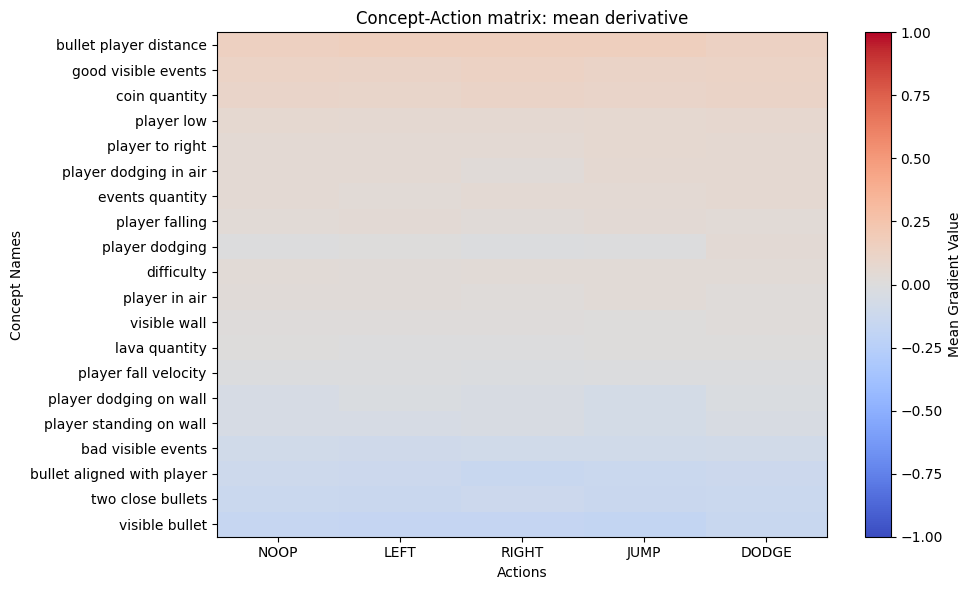

In [15]:
matrix = np.array(list(concept_action_mean_gradient.values()))
matrix = matrix.T

# Calculate the maximum mean gradient value for each concept and get sorted indices
sorted_indices = np.argsort(-matrix.max(axis=1))
sorted_matrix = matrix[sorted_indices]
sorted_concept_names = [concept_names[i] for i in sorted_indices]

# Plotting the sorted matrix
plt.figure(figsize=(10, 6))
plt.imshow(sorted_matrix, cmap='coolwarm', aspect='auto', vmin=-1, vmax=1)
plt.colorbar(label='Mean Gradient Value')
plt.xticks(ticks=range(len(concept_action_mean_gradient)), labels=concept_action_mean_gradient.keys())
plt.yticks(ticks=range(len(sorted_concept_names)), labels=sorted_concept_names)
plt.title('Concept-Action matrix: mean derivative')
plt.xlabel('Actions')
plt.ylabel('Concept Names')
plt.tight_layout()
plt.savefig('figures/conceptual sensitivity/concept-action-mean.png')
plt.show()